In [1]:
import kachaka_base as base
import pickle
import time
import importlib
importlib.reload(base)

<module 'kachaka_base' from 'c:\\Users\\keise\\OneDrive - 信州大学\\授業\\3年\\後期\\機械システム工学プロジェクト\\kachaka_at_ymzk_lab\\kachaka_base.py'>

In [2]:
from kachaka_base import BoxColor, PushingBoxStatus
import numpy as np
import copy
import random


class VirtualKachaka(base.KachakaBase):
    def __init__(self, data_num: int, box_color: BoxColor, noise_stddev: float = 10.0):
        self.box_color = box_color
        self.noise_stddev = noise_stddev

        path = "data/sensor_data" + str(data_num) + "/"

        ratio = 1000
        with open(path + "position.pkl", "rb") as file:
            position = pickle.load(file)
        self.pose = base.Pose(
            position["x"] * ratio, position["y"] * ratio, position["theta"]
        )

        with open(path + "theta.pkl", "rb") as file:
            theta = pickle.load(file)
        with open(path + "dist.pkl", "rb") as file:
            dist = pickle.load(file)
        self.lidar_data = base.LidarData(dist, theta, self.pose)
        self.true_lidar_data = copy.deepcopy(self.lidar_data)

    def move_to_pose(self, distination: base.Pose):
        time.sleep(0.01)
        self.pose = distination

    def update_sensor_data(self):
        def add_noise_to_lidar_data(
            original_lidar_data: base.LidarData, noise_stddev=10.0
        ):
            # コピーを作成
            noisy_lidar_data = copy.deepcopy(original_lidar_data)

            noise_mean = 0

            # ガウシアンノイズを生成
            x_noise = np.random.normal(
                noise_mean, noise_stddev, noisy_lidar_data.x_data.shape
            )
            y_noise = np.random.normal(
                noise_mean, noise_stddev, noisy_lidar_data.y_data.shape
            )

            # データにノイズを加える
            noisy_lidar_data.x_data += x_noise
            noisy_lidar_data.y_data += y_noise

            return noisy_lidar_data

        # ノイズを加えてセンサデータを更新
        self.lidar_data = add_noise_to_lidar_data(
            self.true_lidar_data, self.noise_stddev
        )

    def recognize_box_color(self) -> BoxColor:
        return self.box_color

    def check_pushing_box_by_camera(self) -> PushingBoxStatus:
        rand_num = random.uniform(0, 1)  # 0から1のランダムな浮動小数点数を生成

        if rand_num < 0.8:
            return PushingBoxStatus.PUSHING
        elif rand_num < 0.9:
            return PushingBoxStatus.DROPPED_LEFT
        else:
            return PushingBoxStatus.DROPPED_RIGHT

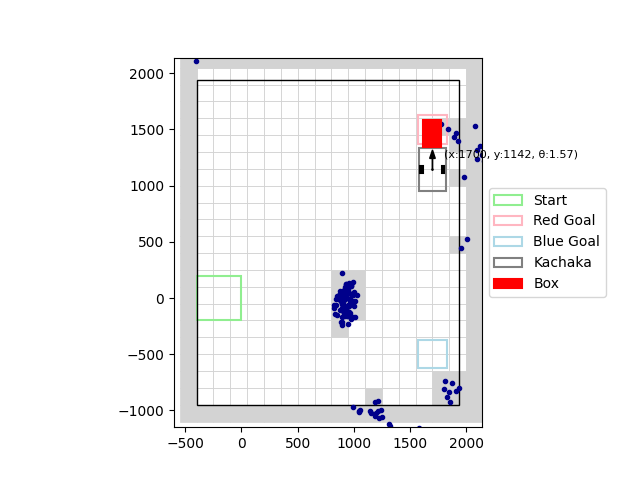

タスクが完了しました


In [3]:
# 初期化処理 ===============================================================
# 仮想のカチャカ初期化---------------------
kachaka = VirtualKachaka(7,BoxColor.RED, 50)
kachaka.pose = base.Pose(0, 0, 0)
logger = base.TextLogger()
logger.log("起動しました")

# 共通の初期化処理-------------------------
# initial_box_pose = base.Pose(1000, 1000, 0)
initial_box_pose = base.Pose(500, 0, 0)
blue_box_goal = base.Pose(1700, -500, 0)
red_box_goal = base.Pose(1700, 1500, 0)
box = base.Box(initial_box_pose)
map = base.GridMap(
    base.Size(2340, 2890),
    grid_size=base.Size(150, 150),
    origin_offset=base.Pose(400, 950, 0),
    start=base.Pose(-200, 0, 0),
    initial_box_pose=initial_box_pose,
    red_box_goal=red_box_goal,
    blue_box_goal=blue_box_goal,
)
trajectory_planner = base.StraightTrajectoryPlanner()
controller = base.Controller(kachaka, box, map, trajectory_planner, logger)

(x_lim, y_lim) = map.get_axes_lim()
margin = 200  # 表示マージン確保
x_lim = (x_lim[0] - margin, x_lim[1] + margin)
y_lim = (y_lim[0] - margin, y_lim[1] + margin)
plotter = base.Plotter(x_lim, y_lim)


# メインループ ===============================================================
while controller.are_all_tasks_done() == False:
    plotter.update(map, box, kachaka, controller.trajectory)
    controller.update()

# GIFアニメーション作成 ======================================================
plotter.close()
plotter.make_gif(duration=200)
plotter.make_zip_package()

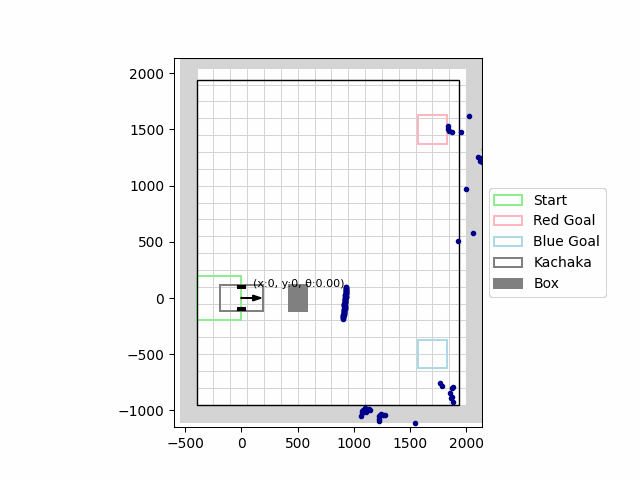

起動しました
箱の前まで移動します
箱の色を読みとります
   赤の箱を検出しました
箱を運ぶ経路を生成します
move_angle=-4.71238898038469
[Pose(x=100.0, y=4.898587196589413e-14, theta=-1.5707963267948966), Pose(x=124.12295168563662, y=-136.80805733026747, theta=-1.221730476396031), Pose(x=193.58222275240877, y=-257.1150438746157, theta=-0.8726646259971647), Pose(x=300.0000000000001, y=-346.4101615137755, theta=-0.5235987755982983), Pose(x=430.54072893322785, y=-393.9231012048832, theta=-0.17453292519943275)]
経路を辿ります
箱を左に落としました．
   経路を修正します
箱を運ぶ経路を生成します
move_angle=4.188790204786391
[Pose(x=525.0, y=-43.30127018922195, theta=-2.617993877991495), Pose(x=394.4592710667721, y=-90.81420988032971, theta=-2.9670597283903604), Pose(x=255.5407289332278, y=-90.81420988032966, theta=2.9670597283903595), Pose(x=125.00000000000003, y=-43.301270189221896, theta=2.617993877991494), Pose(x=18.58222275240871, y=45.993847449938016, theta=2.2689280275926276), Pose(x=-50.877048314363265, y=166.30083399428617, theta=1.919862177193762)]
経路を辿ります
箱を左に落としました．
   

In [4]:
from IPython.display import Image, display

# 生成したGIFアニメーションを表示
display(Image(filename="plotter_output/animation.gif"))
# ログの履歴を表示
logger.show_history()